In [1]:
# Import libraries

import os, sys, warnings
import numpy as np
import matplotlib.pyplot as plt

#sys.path.append('../Environment/')
#from Environment.environment import *
%run ../Environment/environment.ipynb

In [2]:
# # Initialize some variables

# # Restart the environment
# env = EnvironmentState()

# NUM_ACTIONS = 5
# ACTIONS = np.asarray([0, 1, 2, 3, 4])

# NUM_POSITIONS = (env.REGION_HEIGHT/0.05)+1
# NUM_ANGLES    = ((258-102)/3)+1                               # Evironment states include a 
#                                                               # range of angles (102 to 258)
# POS_STATES = np.zeros((int(NUM_POSITIONS), int(NUM_ANGLES)))  # for every y position the agent
# ANG_STATES = np.zeros((int(NUM_POSITIONS), int(NUM_ANGLES)))  # can occupy 

# # Fill the state values
# for i in range(int(NUM_ANGLES)):
#     POS_STATES[:,i] = np.arange(-1*env.REGION_HEIGHT/2, env.REGION_HEIGHT/2+0.05, 0.05)
    
# for i in range(int(NUM_POSITIONS)):
#     ANG_STATES[i,:] = np.arange(102, 258+3, 3)

# # Initialize the Q values
# Q = np.zeros((int(NUM_POSITIONS), int(NUM_ANGLES), int(NUM_ACTIONS)))

# # Resize the states and Q values for easier searching, intersections, and copmarisons
# POS_STATES = np.round(POS_STATES.reshape(int(NUM_POSITIONS*NUM_ANGLES), order = 'F'), 2)
# ANG_STATES = ANG_STATES.reshape(int(NUM_POSITIONS*NUM_ANGLES), order = 'F')
# Q = Q.reshape(int(NUM_POSITIONS*NUM_ANGLES), NUM_ACTIONS, order = 'F')

# # Now Q is a state x action matrix
# # Column 1 is wait action, 2 is pos up, 3 is pos down, 4 is aim up, 5 is aim down
# # Each row corresponds to a (pos & angle) state

In [2]:
# Initialize some variables

# Restart the environment
env = EnvironmentState()

NUM_ACTIONS = 5 # Define the actions
ACTIONS = np.asarray([0, 1, 2, 3, 4])

# Define the state space, defined to be the possible y positions of te agent.
NUM_STATES = (env.REGION_HEIGHT/0.05)+1
STATES = np.round(np.arange(-1*env.REGION_HEIGHT/2, env.REGION_HEIGHT/2+0.05, 0.05),2)

# Initialize the Q values
Q = np.zeros((int(NUM_STATES), int(NUM_ACTIONS)))

# Q is a state x action matrix
# Column 1 is wait action, 2 is pos up, 3 is pos down, 4 is aim up, 5 is aim down
# Each row corresponds to a pos state

In [46]:
# Initialize parameters
NUM_OBS = 1 # Number of obstacles
NUM_STEPS = 100 # Number of steps in an episode
NUM_EPISODES = 1000

alpha = 0.02
eps   = 0.01
gamma = 0.90
#episode = 0
hits = np.zeros((NUM_EPISODES))
R_SUM = np.zeros((NUM_EPISODES))
VAR   = np.zeros((NUM_EPISODES))

# Use a Q-Learning algorithm based on the algorithm on page 131 of Sutton and Barto.
for episode in range(NUM_EPISODES):
    env.initialize()
    env.centered_obstruction()
    #env.randomize_obstruction(NUM_OBS)
    #env.randomize_agent()
    #env.randomize_target()
    #env.randomize(NUM_OBS)
    R_vector = np.zeros((NUM_STEPS))
    n = 0
    while True:
        # Find the current state
        #s = np.where( (POS_STATES == np.round(env._agent_position_y,2)) & (ANG_STATES == env._agent_aiming_angle) )[0]
        s = np.where(STATES == np.round(env._agent_position_y,2))[0]
        
        # Create a policy based on epsilon greedy
        if len(np.unique(Q[s,:])) <= 1: # If all Q values are same, set policy to equal for all actions
            pi = np.zeros((NUM_ACTIONS))
            pi[:] = 1/NUM_ACTIONS
        elif len(np.unique(Q[s,:])) <= 4: # If multiple Q have a max, assign priority to the first max Q value
            pi = np.asarray([((1 - eps) + eps/NUM_ACTIONS if Q[s,i]==np.max(Q[s,:]) else eps/NUM_ACTIONS) for i in range(NUM_ACTIONS)])
            ind = np.where(pi == np.max(pi))[0]
            pi[ind[1:]] = eps/NUM_ACTIONS
        else:
            pi = np.asarray([((1 - eps) + eps/NUM_ACTIONS if Q[s,i]==np.max(Q[s,:]) else eps/NUM_ACTIONS) for i in range(NUM_ACTIONS)])
        
        # Choose and take an action based on policy
        action = np.random.choice(ACTIONS, replace = True, p = pi)
        env.take_action(action)
        
        # With the action taken, the agent is now in the future state s'. Find that state
        #s_prime = np.where( (POS_STATES == np.round(env._agent_position_y,2)) & (ANG_STATES == env._agent_aiming_angle) )[0]
        s_prime = np.where(STATES == np.round(env._agent_position_y,2))[0]
        
        # Collect the reward
        R = env.compute_reward()
        R_vector[n] = R
        
        # Update the Q value
        if len(np.unique(Q[s_prime,:])) <= 1: # If all Q values are the same, use any one
            Q[s,action] = Q[s,action] + alpha*(R + gamma*Q[s_prime,0] - Q[s,action])
        else:
            Q[s,action] = Q[s,action] + alpha*(R + gamma*np.max(Q[s_prime,:]) - Q[s,action])
        
        n = n + 1
        
        # At the end of the episode, determine if the algorithm hit the target and break
        # the loop to move on to the next episode
        if n == NUM_STEPS:
            hits[episode] = 1 if R == 1 else 0 # If agent is aiming at the target, R is 1. 
            R_SUM[episode] = np.sum(R_vector)
            VAR[episode]  = np.var(R_vector) # For the unbiased case, the RSE is the variance
            break

# print(hits)
print(np.sum(hits)/len(hits))

0.041


<IPython.core.display.Javascript object>


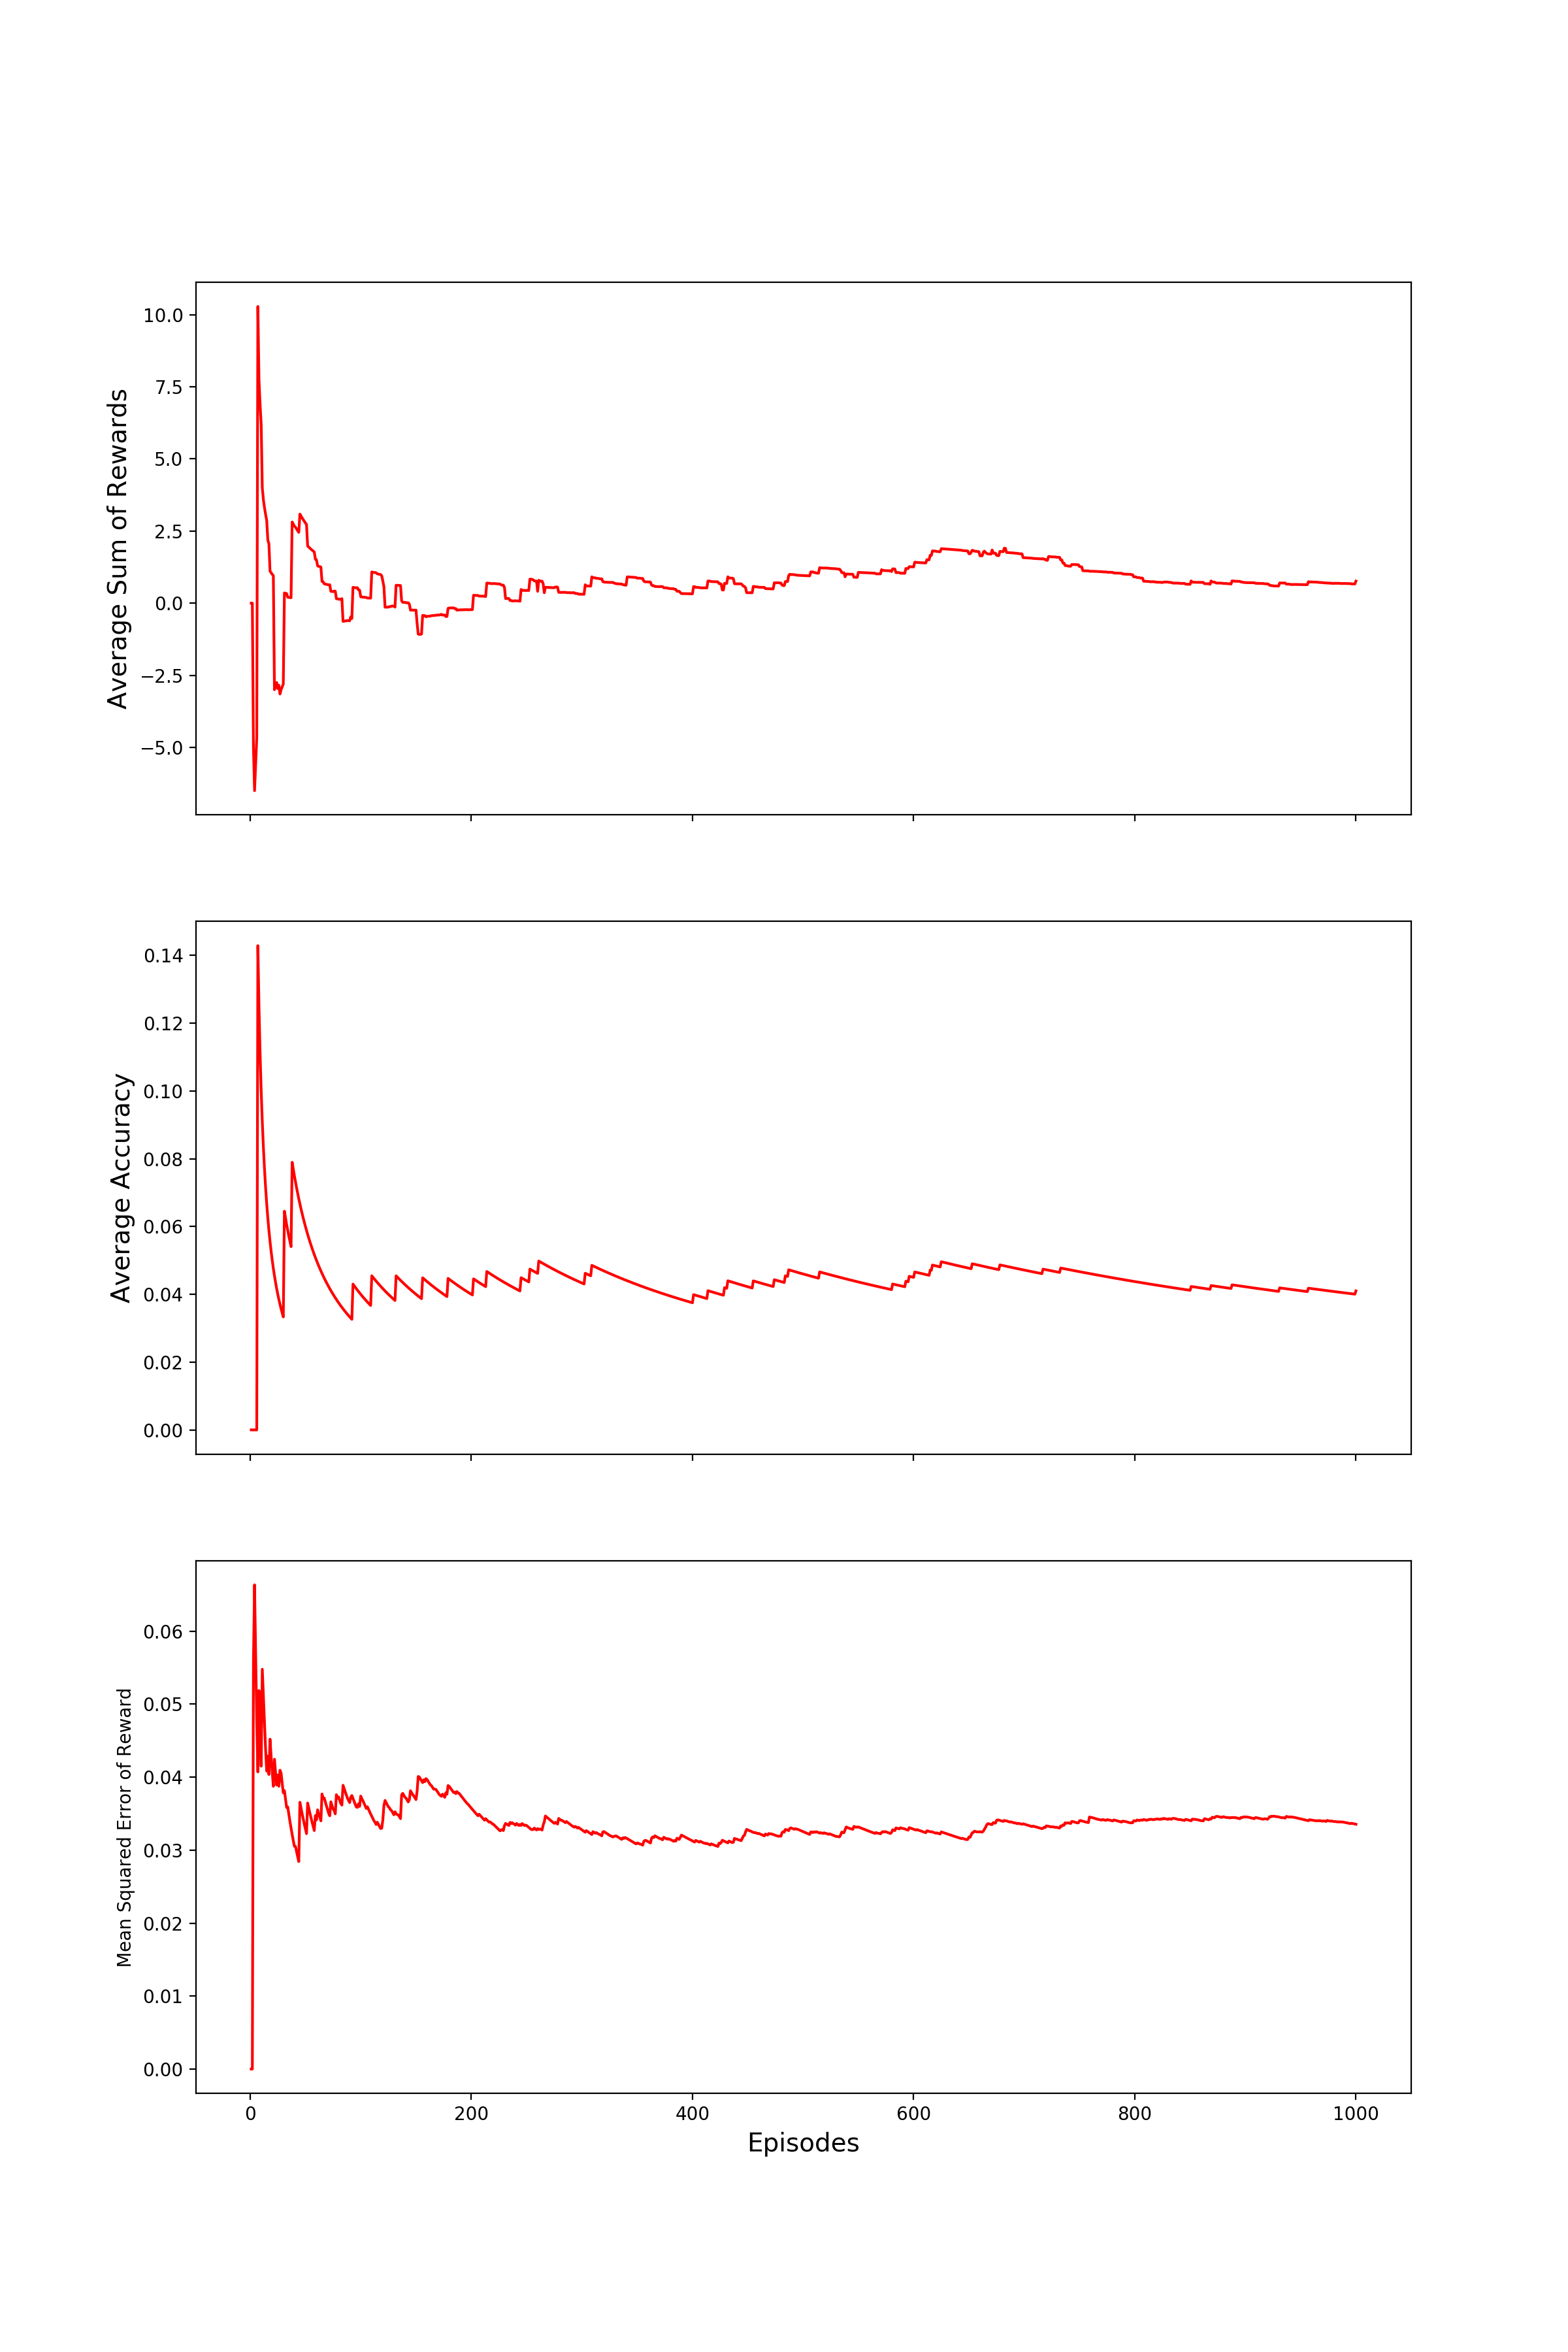

In [47]:
# Example graphs to make:
# Sum of rewards vs. Episodes
# % accuracy vs. Episodes
# RMSE vs. Episodes

episodes = np.arange(1, NUM_EPISODES+1, 1)

R_Sum_Ave = np.zeros((NUM_EPISODES))
accuracy = np.zeros((NUM_EPISODES))
VAR_Ave = np.zeros((NUM_EPISODES))

R_Sum_Ave[0] = R_SUM[0]
R_Sum_Ave[1:] = np.asarray([np.sum(R_SUM[:n])/(n+1) for n in range(1, NUM_EPISODES)])

accuracy[0] = hits[0]
accuracy[1:] = np.asarray([np.sum(hits[:n])/(n+1) for n in range(1, NUM_EPISODES)])

VAR_Ave[0] = VAR[0]
VAR_Ave[1:] = np.asarray([np.sum(VAR[:n])/(n+1) for n in range(1, NUM_EPISODES)])

# Make an example graph
fig, axes = plt.subplots(figsize = [12,18], nrows = 3, ncols = 1, sharex = True)
ax1 = axes[0]; ax2 = axes[1]; ax3 = axes[2]

ax1.plot(episodes, R_Sum_Ave, 'r-')
ax1.set_ylabel('Average Sum of Rewards', fontsize = 14)

ax2.plot(episodes, accuracy, 'r-')
ax2.set_ylabel('Average Accuracy', fontsize = 14)

ax3.plot(episodes, VAR_Ave, 'r-')
ax3.set_ylabel('Mean Squared Error of Reward')
ax3.set_xlabel('Episodes', fontsize = 14)

plt.show(block = False)

In [48]:
# Write the data to a comma seperated text file for comparison with another algorithm.
# Naming format:
# Q-Learning_aa.txt
# aa refers to the refers to the learning rate of the model
#   (e.g., 02 is a learning rate of 0.02)

# Variables saved are:
#   Episodes
#   Hit/Miss for that episode
#   Sum of Rewards for that episode (SR)
#   Mean Square Error (Variance) for that episode (MSE)

# Write the file
f = open('Q-Learning_02.txt', 'w')

# Write the headers
f.write('Episode,Hit,SR,Variance' + '\n')

# Write the data
for n in range(NUM_EPISODES):
    f.write(str(episodes[n]) + ',' + str(hits[n]) + ',' + str(R_SUM[n]) + ',' + str(VAR[n]) + '\n')
    
# Close the file when finished
f.close()